# Recurrent Neural Networks

All the models we have discussed so far were looking at the inputs as isolated instances. In image classification we determine the category of and image, in semantic segmentation we produce a semantic map from the input. But there are many cases were datapoints are not isolated instances and have connection to each other. Sequential data are the type of data where each instance is related to the instances came before. A good example for this type of data is time series data. At each point in time to the value of the time series depends on the value of the prior points. Recurrent Neural Networks (RNN) are a class of networks which deal with sequential data. There are many variants of Recurrent Neural Networks, including:

- Simple Recurrect Neural Networks (Simple RNN - or often just called RNN)
- Long Short-Term Memory (LSTM)
- Gated Recurrent Unit (GRU)

In this notebook we will discuss LSTM; however, the general logic behind all these methods are the same. They only differ in the way they handel information internally. 
<img src='./images/RNN.png'>
<div style="font-size:70%">Recurrent Neural Networks Architecture - Credit to <a href='https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0180944'>Bao et al.</a></div>
At each step a set of values are stored as state of the model ($s$). The state is updated at each step and based on the value of the state the output of the model is calculated by passing state through the output layer ($V$). Also, the model takes an input $x_t$ and passes it through an input layer ($U$), The output of this layer is combined with the state of previous step and creates the new state ($s_t$). What is important here is that the input and output layers are the same for all the sequences of data. What makes the output different at each step are the input values and state of the model. <br>
Various architectures handel updating the state value differently and this is the main difference between Simple RNN, LSTM, and GRU. 

![](images/rnn-train.svg)

![](images/rnn-bptt.svg)

![](images/rnn.svg)

These images are from d2l.ai and open source book

In [1]:
import torch
from torch import nn, optim
from torch import functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import xarray as xr

# Parameters

In [2]:
# Params
device = "cuda" if torch.cuda.is_available() else "cpu"
shift_length = 100
seq_length = 1000
max_lithologies = 12
max_wells = 20


print(f'context length of {0.15*seq_length} m or {seq_length} intervals')
print(f'model can see human labels up to {shift_length*0.15}m above. Or {shift_length} intervals')

context length of 150.0 m or 1000 intervals
model can see human labels up to 15.0m above. Or 100 intervals


# Models

In [3]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(LSTM, self).__init__()
        # Params
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        # High level LSTM library, nn.LSTMCell is a lower level one
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        
        # Final layer
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        seq_len = x.shape[1]
        
        output, (_, _) = self.lstm(x)
        h = output.view(-1, seq_len, self.hidden_size)[:, -1]
        
        return self.linear(h)

## Classification

In this scenario we are drilling downwards, and while well logs are reported instantly, there is a lag in facies of around 15 meter (see diagram), while they are interpreated by a petrophysicist. The problem is we would like to know the facies as soon as possible in order decide if, how, and where to drill.

Lets apply machine learning. There are many ways to set up this problem, and geology is especially hard due to the important of context and the amount of undigitized information (much of it is in the brain of old and grizzled geologists).

In this scenario we will apply an RNN. 
- It will travel down the well
- Input are 
    - the last 200 meters of well logs 
    - and the geologist facies interpreation up to 15 meters ago
- The label is the facies at the point in the well


You may ask: "Isn't it cheating? Because it knows the human labels from 15 meters above?" 

We measure this and it gives a 50% accuracy. So this is the naive baseline that we have to beat.

<img src="images/diagram.png" width="600"/>



In this example we are going to look at well logs which are sequential data as well.

In [4]:


import pandas as pd
import xarray as xr
xf = xr.open_zarr("../../data/processed/geolink_norge_dataset/geolink_norge_well_logs.zarr")
xf = xf.where(xf['Well'].str.startswith('30')).dropna(dim='Well', how='all')
df = xf.to_dataframe().swaplevel()
df['LITHOLOGY_GEOLINK'] = df['LITHOLOGY_GEOLINK'].astype('category')
df['Well'] = df.index.get_level_values(0).astype('category')
df['DEPT'] = df.index.get_level_values(1)
feature_cols = ['CALI', 'DTC', 'GR', 'RDEP', 'RHOB',
       'RMED', 'xc', 'yc', 'DEPT']
df = df.dropna(how='any', subset=feature_cols+['LITHOLOGY_GEOLINK'])
df = df.sort_index()
df

CALI         DTC        Depth         GR  \
Well    DEPT                                                     
30_11-3 2118.60  12.435000  109.432205  2118.744629  62.438549   
        2118.75  12.435000  109.432205  2118.744629  62.438549   
        2118.90  12.584001  102.456642  2118.896973  61.501503   
        2119.05  12.606000   95.108009  2119.049561  61.000000   
        2119.20  12.391000   99.642990  2119.201904  61.905998   
...                    ...         ...          ...        ...   
30_7-7  5022.15   5.961000   81.231377  5022.173828  59.574780   
        5022.30   5.941000   81.126503  5022.326660  60.271767   
        5022.45   5.887000   80.289490  5022.479004  59.796532   
        5022.60   5.902000   78.824585  5022.631348  55.645344   
        5022.75   5.902000   78.824585  5022.631348  55.645344   

                LITHOLOGY_GEOLINK      RDEP      RHOB   RMED  split  \
Well    DEPT                                                          
30_11-3 2118.60              Silt  1.321802  2.305019  1.439  train   
        2118.75              Silt  1.321802  2.305019  1.439  train   
        2118.90              Silt  1.478748  2.317000  1.439  train   
        2119.05              Silt  1.553000  2.327976  1.534  train   
        2119.20              Silt  1.512000  2.312981  1.777  train   
...                           ...       ...       ...    ...    ...   
30_7-7  5022.15              Silt  2.438013  2.455000  2.889  train   
        5022.30              Silt  2.438000  2.463000  2.818  train   
        5022.45              Silt  2.461923  2.455000  2.796  train   
        5022.60              Silt  2.503865  2.465000  2.774  train   
        5022.75              Silt  2.503865  2.465000  2.774  train   

                   wlbCompletionDate  wlbCompletionYear  \
Well    DEPT                                              
30_11-3 2118.60  1983-03-14T00:00:00             1983.0   
        2118.75  1983-03-14T00:00:00             1983.0   
        2118.90  1983-03-14T00:00:00             1983.0   
        2119.05  1983-03-14T00:00:00             1983.0   
        2119.20  1983-03-14T00:00:00             1983.0   
...                              ...                ...   
30_7-7  5022.15  1979-01-07T00:00:00             1979.0   
        5022.30  1979-01-07T00:00:00             1979.0   
        5022.45  1979-01-07T00:00:00             1979.0   
        5022.60  1979-01-07T00:00:00             1979.0   
        5022.75  1979-01-07T00:00:00             1979.0   

                 wlbKellyBushElevation  wlbTotalDepth        xc         yc  \
Well    DEPT                                                                 
30_11-3 2118.60                   25.0         4662.0  2.537631  60.044053   
        2118.75                   25.0         4662.0  2.537631  60.044053   
        2118.90                   25.0         4662.0  2.537631  60.044053   
        2119.05                   25.0         4662.0  2.537631  60.044053   
        2119.20                   25.0         4662.0  2.537631  60.044053   
...                                ...            ...       ...        ...   
30_7-7  5022.15                   25.0         5127.0  2.268694  60.272028   
        5022.30                   25.0         5127.0  2.268694  60.272028   
        5022.45                   25.0         5127.0  2.268694  60.272028   
        5022.60                   25.0         5127.0  2.268694  60.272028   
        5022.75                   25.0         5127.0  2.268694  60.272028   

                    Well     DEPT  
Well    DEPT                       
30_11-3 2118.60  30_11-3  2118.60  
        2118.75  30_11-3  2118.75  
        2118.90  30_11-3  2118.90  
        2119.05  30_11-3  2119.05  
        2119.20  30_11-3  2119.20  
...                  ...      ...  
30_7-7  5022.15   30_7-7  5022.15  
        5022.30   30_7-7  5022.30  
        5022.45   30_7-7  5022.45  
        5022.60   30_7-7  5022.60  
        5022.75   30_7-7


  <div class="alert alert-success">
  <h2>Exercise</h2>

  Are there better ways we should set this up?
    
  What are the benefits?
      

  <details>
  <summary><b>→ Hints</b></summary>

  There is no right answer except experimentation, but on creating this demo we found:
      
  * Generalising to a new well is hard, and it's important to have a similar distribution in test and train. So we took the top of some wells, and the bottom of others as training. 
  * Seeing the previous labels is important, as this encodes how the particular geologist interprets facies in this well. Which can often have some subjectivity
  * Long context help a lot, but also slow it down. We're using the last 200 meters, but seeing the whole well helps
  * Using all wells, instead of just the 30* wells will help it learn to generalise
  * Using all logs may help
  * We could do infilling instead
  * We could make it bi-directional
  * We could make it a sequence to sequence model, instead of sequence to 1
  * Transformer may do better
  * We could normalise the logs per window or well
  * Many more

  </details>

  </div>

In [5]:
# We  will stick to a gorup of long wells 29, 30, 31, 35 are valid groups
# df=df[df['Well'].str.startswith('30')]
counts = df['Well'].value_counts()
counts[counts>0]

30_4-1      23291
30_7-7      18949
30_2-1      15674
30_11-3     13021
30_6-11     12994
30_3-2 R    11046
30_6-8      10965
30_6-5      10882
30_3-3      10209
30_3-4 R     8715
30_6-23      8233
30_6-14      7080
30_4-2       7039
30_3-5 S     4207
30_6-22      3639
Name: Well, dtype: int64

In [6]:
# Let take the top N lithologies, replacing the rest with "rare"
# print(len(df))
removed_labels = df["LITHOLOGY_GEOLINK"].value_counts()[max_lithologies:].index
print(df['LITHOLOGY_GEOLINK'].value_counts())
print('removed_labels', removed_labels)
l = df["LITHOLOGY_GEOLINK"].values.remove_categories(removed_labels)
df['LITHOLOGY_GEOLINK']  = l.add_categories('rare').fillna('rare')
df['LITHOLOGY_GEOLINK'].value_counts()

Shaly Silt                41607
Marlstone                 40738
Silt                      36834
Argillaceous Limestone    12329
Cross Bedded Sst          10106
Silty Shale                7366
Silty Sand                 5522
Cinerite                   3721
Limestone                  3708
Sandstone                  1702
Calcareous Cement          1381
Coal                        930
                              0
Name: LITHOLOGY_GEOLINK, dtype: int64
removed_labels CategoricalIndex([''], categories=['', 'Argillaceous Limestone', 'Calcareous Cement', 'Cinerite', 'Coal', 'Cross Bedded Sst', 'Limestone', 'Marlstone', ...], ordered=False, dtype='category')


Shaly Silt                41607
Marlstone                 40738
Silt                      36834
Argillaceous Limestone    12329
Cross Bedded Sst          10106
Silty Shale                7366
Silty Sand                 5522
Cinerite                   3721
Limestone                  3708
Sandstone                  1702
Calcareous Cement          1381
Coal                        930
rare                          0
Name: LITHOLOGY_GEOLINK, dtype: int64

In [7]:
removed_labels = list(df["LITHOLOGY_GEOLINK"].value_counts()[12:].keys())
i = df["LITHOLOGY_GEOLINK"].values.remove_categories(removed_labels)
i[i.isna()]

[], Categories (12, object): ['Argillaceous Limestone', 'Calcareous Cement', 'Cinerite', 'Coal', ..., 'Shaly Silt', 'Silt', 'Silty Sand', 'Silty Shale']

In [8]:
# Remove unused categories, and order
df['LITHOLOGY_GEOLINK'] = df['LITHOLOGY_GEOLINK'].values.remove_unused_categories()

# sort categories (leads to nicer histograms)
i = df['LITHOLOGY_GEOLINK'].values
litho_sorted = i.value_counts().sort_values(ascending=True).index
df['LITHOLOGY_GEOLINK'] = i.reorder_categories(list(litho_sorted), ordered=True)

df['LITHOLOGY_GEOLINK'].values.categories

Index(['Coal', 'Calcareous Cement', 'Sandstone', 'Limestone', 'Cinerite',
       'Silty Sand', 'Silty Shale', 'Cross Bedded Sst',
       'Argillaceous Limestone', 'Silt', 'Marlstone', 'Shaly Silt'],
      dtype='object')

Shaly Silt                41607
Marlstone                 40738
Silt                      36834
Argillaceous Limestone    12329
Cross Bedded Sst          10106
Silty Shale                7366
Silty Sand                 5522
Cinerite                   3721
Limestone                  3708
Sandstone                  1702
Calcareous Cement          1381
Coal                        930
Name: LITHOLOGY_GEOLINK, dtype: int64

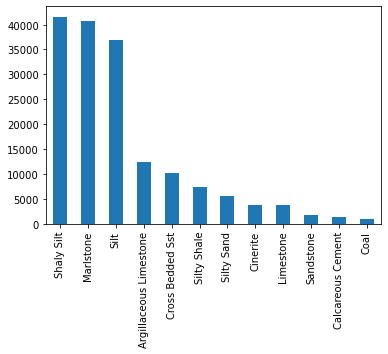

In [9]:
df['LITHOLOGY_GEOLINK'].value_counts().plot.bar()
df['LITHOLOGY_GEOLINK'].value_counts()

In [10]:
# Add a well int, so the model will know what well we use
well_index = df['Well'].values
well_int = well_index.rename_categories(range(len(well_index.categories))).astype(int)
df['Well_int']= well_int
df[['Well_int']]

Well_int
Well    DEPT             
30_11-3 2118.60         0
        2118.75         0
        2118.90         0
        2119.05         0
        2119.20         0
...                   ...
30_7-7  5022.15        14
        5022.30        14
        5022.45        14
        5022.60        14
        5022.75        14

[165944 rows x 1 columns]

In [11]:
# Select the N longest well logs
wells = sorted(df['Well'].unique())
n_wells = min(len(wells), max_wells)
selected_wells = wells[:n_wells]
df = df.loc[selected_wells]
# df

1

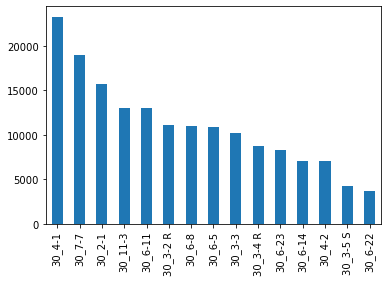

In [12]:
# Get a list of wells, ordered by frequency
well_counts = df['Well'].value_counts()
well_counts = well_counts[well_counts>0]
wells = list(well_counts.index)
well_counts.plot.bar()
1
# well_counts

In [13]:
# We want to see the facies N intervals above

df['LITH_ABV'] = df["LITHOLOGY_GEOLINK"].shift(shift_length).fillna('Shaly Silt')
df['LITH_ABV_INT'] = df['LITH_ABV'].values.codes
df[['LITHOLOGY_GEOLINK', 'LITH_ABV']]

LITHOLOGY_GEOLINK          LITH_ABV
Well    DEPT                                       
30_11-3 2118.60              Silt        Shaly Silt
        2118.75              Silt        Shaly Silt
        2118.90              Silt        Shaly Silt
        2119.05              Silt        Shaly Silt
        2119.20              Silt        Shaly Silt
...                           ...               ...
30_7-7  5022.15              Silt              Silt
        5022.30              Silt              Silt
        5022.45              Silt              Silt
        5022.60              Silt  Cross Bedded Sst
        5022.75              Silt  Cross Bedded Sst

[165944 rows x 2 columns]

## Data processing

### Split data

In [14]:
# SPLIT: We will train on measurements above Xkm depth, and test on deeper ones
from functools import partial

def get_depth_thresh(x, even_bottom=True):
    """
    On even number well codes take the bottom of the well for trainin
    """
    if len(x)==0: return x
    
    # if the well code is even take the top 
    code_is_even = (x['Well'].values.codes[0]%2)==0
    if code_is_even:
        even_bottom = not even_bottom
    
    d = x['DEPT']
    thresh = np.round(d.mean())
    x['thresh'] = thresh
    if even_bottom:
        return x[d>thresh]
    else:
        return x[d<thresh]


df_test = df.groupby(level=0).apply(partial(get_depth_thresh, even_bottom=False))
df_train = df.groupby(level=0).apply(partial(get_depth_thresh, even_bottom=True))
print('train', df_train.shape, 'test', df_test.shape)
print(f'Train {len(df_train)/len(df):.0%}, test {len(df_test)/len(df):.0%}')

train (83611, 21) test (82324, 21)
Train 50%, test 50%


In [15]:
train = []
test = []
for i, well in enumerate(selected_wells):
    df_well = df.loc[well]
    df_well.name = well
    i_halfway = int(len(df_well)*0.5)
    df_top = df_well.iloc[:i_halfway]
    df_bottom = df_well.iloc[i_halfway:]
    is_even = i%2==0
    if is_even==0:
        train.append(df_top)
        test.append(df_bottom)
    else:
        train.append(df_bottom)
        test.append(df_top)
        
df_test = pd.concat(test).set_index(['Well', 'DEPT'], drop=False)
df_train = pd.concat(train).set_index(['Well', 'DEPT'], drop=False)
print('train', df_train.shape, 'test', df_test.shape)
print(f'Train {len(df_train)/len(df):.0%}, test {len(df_test)/len(df):.0%}')

train (82972, 20) test (82972, 20)
Train 50%, test 50%


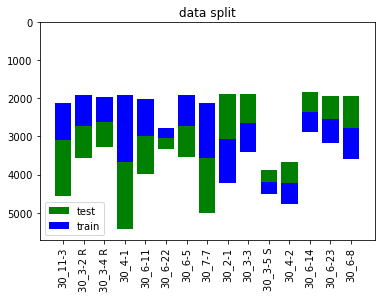

In [16]:
# Plot the data split
well_split = []
for i, well in enumerate(selected_wells):
    df_well = df.loc[well]
    i_halfway = int(len(df_well)*0.5)
    is_even = i%2==0
    well_split.append(dict(
        well=well,
        top=df_well.Depth.min(),
        half=df_well.Depth.iloc[i_halfway],
        bottom=df_well.Depth.max(),
        train_top=is_even,
    ))
    
df_well_split = pd.DataFrame(well_split)

well_top = df_well_split[df_well_split.train_top]
well_bottom = df_well_split[~df_well_split.train_top]

# Do the ones where train is at top
plt.bar(
    x=well_top.well,
    height=well_top.bottom,
    color="green",
    label="test"
)
plt.bar(
    x=well_top.well,
    height=well_top.half,
    color="blue",
    label="train"
)
plt.bar(
    x=well_top.well,
    height=well_top.top,
    color="white",
)


# Others
plt.bar(
    x=well_bottom.well,
    height=well_bottom.bottom,
    color="blue",
)
plt.bar(
    x=well_bottom.well,
    height=well_bottom.half,
    color="green",
)
plt.bar(
    x=well_bottom.well,
    height=well_bottom.top,
    color="white",
)
plt.gca().invert_yaxis()

plt.legend()
plt.title('data split')
plt.xticks(rotation=90)
plt.show()

In [17]:
a=set(df_train.index)
b=set(df_test.index)
assert len(a.intersection(b))==0

We will be using depth and other measurements to determine the lithology. We dealt with the same problem in the tablular data. But in tabular data we only look at the measurements at each depth to find the class, while here we can look at the variations in the measurements as well.

And add depth as a feature column:

As usual we need to create a training and test set. here we will only use `15` wells for training and `15` for testing as using the entire dataset means we need to spend much longer time for training.

We need to process the input and target data. The input data needs to be normalised with a standard scaler, and the output data needs to be converted from text to numbers. To convert text to numbers we use `LabelEncoder` from Scikit Learn.

### Scale

In [18]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()

# Make a encoder, that order by frequency
encoder = LabelEncoder()

# TODO need to embed prev val..., one hot, then append
encoder.classes_ = df["LITHOLOGY_GEOLINK"].values.categories
print(encoder.classes_)
feat_cols = feature_cols = ['CALI', 'DTC', 'GR', 'RDEP', 'RHOB', 'RMED', 'xc', 'yc', 'DEPT', "LITH_ABV_INT"]
scaler.fit(df[feat_cols].values)

Index(['Coal', 'Calcareous Cement', 'Sandstone', 'Limestone', 'Cinerite',
       'Silty Sand', 'Silty Shale', 'Cross Bedded Sst',
       'Argillaceous Limestone', 'Silt', 'Marlstone', 'Shaly Silt'],
      dtype='object')


StandardScaler()

`LabelEncoder` converts each type to a value.

In [19]:
encoder.transform(["Shaly Silt"])

array([5])

Now we can check the types at various depths:

The output of a classification model is a value for each type. The type with the highest value is the one the model thinks is most likely to be associated with the input data. Therefore, the output size of the model should be the number of types.

Let's create training and test set, similar to what we had in multivariate time series. The only difference is here for each sequence of values we want the model to predict a value for each type.

### To pytorch sequences

In [20]:


def get_sequences(df, seq_length = 10):
    """Take moving sequences of a dataframe"""
    

    x = []
    y = []
    features = scaler.transform(df.loc[:, feat_cols].values)
    targets = encoder.transform(df.loc[:, "LITHOLOGY_GEOLINK"])

    # Add prev labels, as one hot, to inputs
    one_hot_targets = np.eye(len(encoder.classes_))[targets]
    prev_one_host_targets = np.roll(one_hot_targets, shift=shift_length)
    features = np.concatenate([features, prev_one_host_targets], 1)

    for i in range(len(targets) - seq_length):
        xi = features[i : i + seq_length, :]
        yi = targets[i + seq_length - 1]
        x.append(xi)
        y.append(yi)
    return x, y

# Note we give it prev lithology from 20:10 steps above
# And logs from 20:0 steps abov
x_train, y_train = get_sequences(df_train, seq_length=seq_length)
x_test, y_test = get_sequences(df_test, seq_length=seq_length)

In [31]:
import torch
import torch.utils.data

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        x = x.cpu().detach().numpy()
    return x

def show_distribution(y, label):
    y = to_numpy(y)
    plt.hist(y, output_size * 2, alpha=0.5, label=label)
    plt.xticks(ticks=range(len(encoder.classes_)), labels=encoder.classes_, rotation=90)

class NumpyDataset(torch.utils.data.Dataset):
    """Dataset wrapping arrays.
    Each sample will be retrieved by indexing array along the first dimension.
    Arguments:
        *arrays (numpy.array): arrays that have the same size of the first dimension.
    """

    def __init__(self, *arrays):
        self.arrays = arrays

    def __getitem__(self, index):
        return tuple(array[index] for array in self.arrays)

    def __len__(self):
        return len(self.arrays[0])
dset_train = NumpyDataset(x_train, y_train)
load_train = torch.utils.data.dataloader.DataLoader(dset_train, batch_size=10, pin_memory=True, shuffle=True)
# next(iter(load_train))

In [32]:
output_size = len(df["LITHOLOGY_GEOLINK"].unique())

It is important that we make sure the training and test set have close distribution. For instance, if there is a certain type in test data that doesn't exist in training data, the model will not be able to predict it.

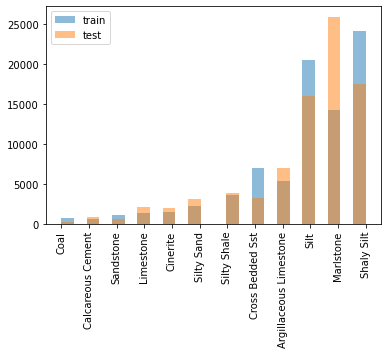

In [33]:
show_distribution(y_train, 'train')
show_distribution(y_test, 'test')
plt.legend()
plt.show()

## Baseline accuracy

When you experiment with a machine learning problem it's important to use a baseline, to check if the model is actually doing any work. Sometimes you can use humans, or a prior work, but in novel problems we look at a naive answer, then aim to do better.

Below we investigate several methods of naive estimation and try to beat the best.

In [34]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
score_fn=accuracy_score

true = np.array(y_test)
for strategy in ["most_frequent", "stratified", "prior", "uniform"]:
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(x_train, y_train)
    score = dummy_clf.score(x_test, y_test)
    print(f"baseline accuracy={score:2.2%} for {strategy}")

baseline accuracy=21.26% for most_frequent
baseline accuracy=17.95% for stratified
baseline accuracy=21.26% for prior
baseline accuracy=8.20% for uniform


In [35]:
print(f'context length of {0.15*seq_length} m or {seq_length} intervals')
print(f'model can see human labels up to {shift_length*0.15}m above. Or {shift_length} intervals')

context length of 150.0 m or 1000 intervals
model can see human labels up to 15.0m above. Or 100 intervals


In [36]:
# Prev litho Baseline
pred_baseline = np.roll(true, shift=shift_length)
score=score_fn(true, pred_baseline)
print(f'baseline accuracy {score:2.2%} for prev {shift_length} facies values')

baseline accuracy 62.22% for prev 100 facies values


## Train

Note that this can be simplified with libraries like pytorch lightning or fastai, but they are not yet approved at many companies.

In [41]:
def training_loop(epochs=1, bs=128, max_epoch_iters=128*128):
    
    def train():
        model.train()

        training_loss = []
        training_accuracy = []

        dset_train = NumpyDataset(x_train, y_train)
        train_set_samplers=np.random.choice(list(range(len(dset_train))), max_epoch_iters)
        load_train = torch.utils.data.dataloader.DataLoader(
            dset_train, 
            batch_size=bs, pin_memory=True,# shuffle=True,
            sampler=train_set_samplers
        )

        for x, y in tqdm(load_train, leave=False, desc='train'):
            x = x.float().to(device)
            y = y.long().to(device)

            optimizer.zero_grad()
            preds = model(x)
            loss = loss_func(preds, y)
            loss.backward()
            optimizer.step()

            training_loss.append(loss.item())
            accuracy = score_fn(
                to_numpy(y), to_numpy(preds).argmax(-1)
            )
            training_accuracy.append(accuracy)
        
        return [np.mean(training_loss), np.mean(training_accuracy)]

    def test():
        model.eval()
        test_loss = []
        test_accuracy = []

        dset_test = NumpyDataset(x_test[:max_epoch_iters//4], y_test[:max_epoch_iters//4])
        load_test = torch.utils.data.dataloader.DataLoader(dset_test, batch_size=bs, pin_memory=True)
        for x, y in tqdm(load_test, leave=False, desc='test'):
            x = x.float().to(device)
            y = y.long().to(device)
            preds = model(x)
            loss = loss_func(preds, y)
            test_loss.append(loss.item())
            accuracy = score_fn(
                to_numpy(y), to_numpy(preds.argmax(-1))
            )
            test_accuracy.append(accuracy)
        return [np.mean(test_loss), np.mean(test_accuracy)]

    all_losses = []
    all_accuracys = []
    try:
        test_loss, test_acc = test()
        print(
                f"Start: Test Loss = {test_loss:.2f}, accuracy = {test_acc:.3f}"
            )
        for epoch in tqdm(range(epochs), desc='epochs'):
            loss, acc = train()
            print(f"Epoch {epoch+1}/{epochs}: Training Loss = {loss:.2f}, accuracy = {acc:.3f}")
            
            test_loss, test_acc = test()
            print(
                f"Epoch {epoch+1}/{epochs}: Test Loss = {test_loss:.2f}, accuracy = {test_acc:.3f}"
            )
            print("-" * 50)
        
            all_losses.append([loss, test_loss])
            all_accuracys.append([acc, test_acc])
            
    except KeyboardInterrupt:
        pass

    # Visualising the results
    all_losses = np.array(all_losses)
    plt.plot(all_losses[:, 0], label="Training")
    plt.plot(all_losses[:, 1], label="Test")
    plt.title("Loss")
    plt.legend()
    
    plt.figure()
    all_accuracys = np.array(all_accuracys)
    plt.plot(all_accuracys[:, 0], label="Training")
    plt.plot(all_accuracys[:, 1], label="Test")
    plt.title("accuracy")
    plt.legend()

In [42]:
model = LSTM(
    input_size=x_train[0].shape[-1],
    hidden_size=64,
    num_layers=3,
    output_size=output_size,
)
model = model.to(device)
model

LSTM(
  (lstm): LSTM(22, 64, num_layers=3, batch_first=True)
  (linear): Linear(in_features=64, out_features=12, bias=True)
)

In [43]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss().to(device)

Let's train for 10 epochs

In [ ]:
training_loop(15, 128)

In [ ]:
# Run test
dset_test = NumpyDataset(x_test, y_test)
dload_test = torch.utils.data.dataloader.DataLoader(dset_test, batch_size=512, num_workers=6)

preds = []
true = []
model.eval()
with torch.no_grad():
    for x, y in tqdm(dload_test, desc='predict'):
        pred = model(x.float().to(device))
        preds.append(to_numpy(pred))
        true.append(y)
        
preds = np.concatenate(preds, 0).argmax(axis=-1)
true = np.concatenate(true, 0)

In [ ]:
# ours
print('test acc', score_fn(true, preds))

In [ ]:
import pandas as pd
import sklearn.metrics
import numpy as np

def classification_report(*args, **kwargs):
    out_df = pd.DataFrame(sklearn.metrics.classification_report(*args, **kwargs, output_dict=True)).T
    # Order cols
    out_df[["precision","recall","f1-score","support"]]  
    # Round
    out_df[["precision","recall","f1-score"]]= out_df[["precision","recall","f1-score"]].apply(lambda x: round(x,2))
    out_df[["support"]]= out_df[["support"]].apply(lambda x: x.astype(np.int))
    return out_df

In [ ]:
# pred_baseline = np.roll(true, shift=shift_length)
# df_report = classification_report(true, pred_baseline, labels=range(len(encoder.classes_)), target_names=encoder.classes_)
# df_report[df_report.support>0]

In [ ]:
df_report = classification_report(true, preds, labels=range(len(encoder.classes_)), target_names=encoder.classes_)
df_report[df_report.support>0]

In [ ]:
cm = sklearn.metrics.confusion_matrix(true, preds, labels=range(len(encoder.classes_)))

plt.figure(figsize=(20, 20))
plt.title('Confusion Matrix')
ax=plt.gca()
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=encoder.classes_)
disp.plot(ax=ax, xticks_rotation=90)
plt.show()

## Plot results

In [ ]:
well_name = "30_4-1"
logs = df.loc[well_name].sort_index()

In [ ]:
x_test, y_test = get_sequences(logs)

x_test = torch.Tensor(x_test)#.to(device)
y_test = torch.LongTensor(y_test)#.to(device)

preds = to_numpy(model(x_test.to(device)).argmax(axis=-1))

In [ ]:
df_log_results = logs.iloc[10:].copy()
df_log_results['pred'] = pd.Categorical(encoder.inverse_transform(preds), categories=df_log_results.LITHOLOGY_GEOLINK.values.categories)
df_log_results[['LITHOLOGY_GEOLINK', 'pred']]

In [ ]:
from deep_ml_curriculum.visualization.well_log import plot_well_pred
plot_well_pred(well_name, df_log_results,
               facies_true=df_log_results.LITHOLOGY_GEOLINK.values, 
               facies_pred=df_log_results.pred.values)
plt.show()

- context length of 150.0 m or 1000 intervals
- model can see human labels up to 15.0m above. Or 100 intervals
- baseline accuracy 49.82% for prev 100 facies values


In [ ]:
from deep_ml_curriculum.visualization.well_log import plot_well_pred
tail=1000
plot_well_pred(well_name, df_log_results.iloc[-tail:],
               facies_true=df_log_results.iloc[-tail:].LITHOLOGY_GEOLINK.values, 
               facies_pred=df_log_results.iloc[-tail:].pred.values)
plt.show()

As we saw in the previous examples the model requires training over 100s of epochs to reach the best results. However, in this example due to large size of dataset and the model we stopped after `10` epochs. Try increasing the number of epochs to see how it will affect the accuracy.<br>

Obviously the model right now is not performing well. But there are number ways we can improve it:
1. Training for longer. instead of stopping after `10` epochs go for longer.
2. Increase the hidden state size.
3. Increase the size of training data by adding data from more wells to training. 
4. Increase the size of the sequences so the model get to look further in the history.

#### Exercise 2
Try one of the options above to improve the model.

In [ ]:
# Code Here

Let's have a look at model's predictions.

The distribution of data shows that the model is too focused on type `17` and `18` which is why we are having low accuracy.


<div class="alert alert-success">
    
### Solutions  
<details><summary>See solutions</summary>

<details><summary>Exercise 1</summary>
<b>Increase sequence length to 18</b>

```Python
seq_length = 18
x, y = create_seq_data(data,seq_length)
xtrain = x[:100,:,:]
ytrain = y[:100,:]
xtest = x[100:,:,:]
ytest = y[100:,:]
model = LSTM(1, 50, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_model(model, xtrain, ytrain, 500)
```
<b>Change model size to 100</b>
```Python
model = LSTM(1, 100, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_model(model, xtrain, ytrain, 500)
```

</details>
<details><summary>Exercise 2</summary>
    <b>Larger hidden size</b>
    
```Python
model = LSTM(
    input_size=len(feat_cols),
    hidden_size=400,
    num_layers=1,
    output_size=output_size,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_loop(10, 1024)
```

<b>Train longer</b>
    
```Python
model = LSTM(
    input_size=len(feat_cols),
    hidden_size=200,
    num_layers=1,
    output_size=output_size,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_loop(20, 1024)
```
 
</details>
</details>
</div>

## Further Reading
- [Introduction to RNN](http://slazebni.cs.illinois.edu/spring17/lec02_rnn.pdf)
- [A friendly introduction to Recurrent Neural Networks](https://www.youtube.com/watch?v=UNmqTiOnRfg)
- [Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)](https://www.youtube.com/watch?v=WCUNPb-5EYI&t=97s)
- [Introduction to LSTM](https://medium.com/x8-the-ai-community/a-7-minute-introduction-to-lstm-5e1480e6f52a)
- [LSTM and GRU](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
- [Time Series Prediction with LSTM](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)
- [Building RNN from scratch](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
